See the blogpost on [Autoencoders for extremely rare events](https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098) for more details

In [26]:
# import packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, Dense, Layer, InputSpec
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, activations, initializers, constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, precision_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn import decomposition

from numpy.random import seed
seed(1)

In [5]:
LABELS = ["not","isa"]

# 0. Prepare train and validation for one hot encoded normal distribution data

In [6]:
# only test the approach on one fold in cross validation
# get first train and validation fold and subset to relevant data
train = pd.read_csv('/path/to/9_FINAL/data/machine_learning/two_class/one-hot-ecoding/train/cross_validation/training_fraction_normal_distribution/training_0.csv', 
                    sep=";", index_col=0)
train.head()

/home/linda/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,instance,class,frequency,pidspread,pldspread,id,pids,p1,p10,p11,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,taco,museum,3,2,3,303665257,"['p3a', 'p3a', 'p8a']",0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,auster,servant,2,1,2,440879128,['p8a'],0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,joy,crop,1,1,1,249496097,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,libertarian,invasion,3,2,3,461763252,"['p8a', 'p8d']",0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,blonsky,woman,1,1,1,39589698,['p8a'],0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
# only get relevant data
train.drop(['instance', 'class', 'frequency', 'pldspread', 'pidspread',
           'id', 'pids'], inplace=True, axis=1)
train.head()

,p1,p10,p11,p12a,p12b,p12c,p13,p14,p15a,p15b,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
# separate train to 0 and 1
train_0 = train[train['label'] == 0].reset_index(drop=True)
train_1 = train[train['label'] == 1].reset_index(drop=True)

train_0_x = train_0.drop(['label'], axis=1)
train_1_x = train_1.drop(['label'], axis=1)

# Sanity check
print(f'Shape train_0 {train_0_x.shape}')

Shape train_0 (1040008, 58)


In [9]:
# Sanity check
print(f'Shape train_1 {train_1_x.shape}')

Shape train_1 (18276, 58)


In [10]:
# get first train and validation fold and subset to relevant data
validation = pd.read_csv('/path/to/9_FINAL/data/machine_learning/two_class/one-hot-ecoding/train/cross_validation/validation/val_fold_0.csv',
                        sep=";", index_col=0)
validation.head()

,instance,class,frequency,pidspread,pldspread,id,pids,p1,p10,p11,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,cuxhaven,channel,1,1,1,343190981,['p23b'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,opioid,vasodilator,1,1,1,453050043,['p5'],0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,industry,estuary,2,1,2,344166346,['p3a'],0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,screenwriting,art,17,3,16,240868865,"['p8ap3a', 'p8a', 'p3a', 'p8a', 'p20c', 'p8a',...",0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,stick,monument,3,3,3,297345077,"['p21a', 'p8b', 'p8a']",0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [11]:
validation.drop(['instance', 'class', 'frequency', 'pldspread', 'pidspread',
           'id', 'pids'], inplace=True, axis=1)
validation.head()

,p1,p10,p11,p12a,p12b,p12c,p13,p14,p15a,p15b,...,p42,p43,p5,p6,p7,p8a,p8b,p8c,p8d,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [12]:
# separate validation to 0 and 1
validation_0 = validation[validation['label'] == 0].reset_index(drop=True)
validation_1 = validation[validation['label'] == 1].reset_index(drop=True)

validation_0_x = validation_0.drop(['label'], axis=1)
validation_1_x = validation_1.drop(['label'], axis=1)

# Sanity check
print(f'Shape validation_0 {validation_0_x.shape}')

Shape validation_0 (1300010, 58)


# 1. Initialize Autoencoder

In [13]:
# initialize autoencoder
nb_epoch = 200
batch_size = 128
input_dim = train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1888      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 58)                1914      
Total params: 5,146
Trainable params: 5,146
Non-trainable params: 0
_________________________________________________________

# 2. Train Autoencoder with data = 0

In [14]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="./models/autoencoder_classifier.h5",
                     save_best_only=True,
                     verbose=0)

tb = TensorBoard(log_dir='logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_0_x, train_0_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(validation_0_x, validation_0_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 1040008 samples, validate on 1300010 samples
Epoch 1/200
1040008/1040008 [==============================] - 19s 18us/step - loss: 0.0297 - accuracy: 0.3160 - val_loss: 0.0247 - val_accuracy: 0.3430
Epoch 2/200
1040008/1040008 [==============================] - 21s 20us/step - loss: 0.0246 - accuracy: 0.3407 - val_loss: 0.0245 - val_accuracy: 0.3430
Epoch 3/200
1040008/1040008 [==============================] - 22s 21us/step - loss: 0.0246 - accuracy: 0.3411 - val_loss: 0.0245 - val_accuracy: 0.3430
Epoch 4/200
1040008/1040008 [==============================] - 20s 19us/step - loss: 0.0246 - accuracy: 0.3410 - val_loss: 0.0245 - val_accuracy: 0.3430
Epoch 5/200
1040008/1040008 [==============================] - 19s 18us/step - loss: 0.0246 - accuracy: 0.3410 - val_loss: 0.0247 - val_accuracy: 0.3430
Epoch 6/200
1040008/1040008 [==============================] - 19s 18us/step - loss: 0.0247 - accuracy: 0.3416 - val_loss: 0.0246 - val_accuracy: 0.3470
Epoch 7/200
1040008/1040008 

Epoch 54/200
1040008/1040008 [==============================] - 17s 16us/step - loss: 0.0247 - accuracy: 0.3425 - val_loss: 0.0247 - val_accuracy: 0.3430
Epoch 55/200
1040008/1040008 [==============================] - 19s 18us/step - loss: 0.0249 - accuracy: 0.3424 - val_loss: 0.0249 - val_accuracy: 0.3430
Epoch 56/200
1040008/1040008 [==============================] - 19s 18us/step - loss: 0.0250 - accuracy: 0.3423 - val_loss: 0.0248 - val_accuracy: 0.3430
Epoch 57/200
1040008/1040008 [==============================] - 18s 17us/step - loss: 0.0252 - accuracy: 0.3421 - val_loss: 0.0247 - val_accuracy: 0.3430
Epoch 58/200
1040008/1040008 [==============================] - 18s 17us/step - loss: 0.0252 - accuracy: 0.3419 - val_loss: 0.0248 - val_accuracy: 0.3431
Epoch 59/200
1040008/1040008 [==============================] - 18s 17us/step - loss: 0.0252 - accuracy: 0.3421 - val_loss: 0.0267 - val_accuracy: 0.3430
Epoch 60/200
1040008/1040008 [==============================] - 18s 17us/ste

Epoch 160/200
1040008/1040008 [==============================] - 19s 19us/step - loss: 0.0249 - accuracy: 0.3398 - val_loss: 0.0247 - val_accuracy: 0.3276
Epoch 161/200
1040008/1040008 [==============================] - 18s 17us/step - loss: 0.0248 - accuracy: 0.3392 - val_loss: 0.0248 - val_accuracy: 0.3430
Epoch 162/200
1040008/1040008 [==============================] - 17s 17us/step - loss: 0.0248 - accuracy: 0.3395 - val_loss: 0.0246 - val_accuracy: 0.3430
Epoch 163/200
1040008/1040008 [==============================] - 16s 15us/step - loss: 0.0248 - accuracy: 0.3395 - val_loss: 0.0246 - val_accuracy: 0.3473
Epoch 164/200
1040008/1040008 [==============================] - 19s 19us/step - loss: 0.0248 - accuracy: 0.3395 - val_loss: 0.0246 - val_accuracy: 0.3430
Epoch 165/200
1040008/1040008 [==============================] - 18s 18us/step - loss: 0.0249 - accuracy: 0.3396 - val_loss: 0.0251 - val_accuracy: 0.3430
Epoch 166/200
1040008/1040008 [==============================] - 16s 1

# 3. Reconstruction for classification

In [15]:
# get validation set without label
validation_x = validation.drop(['label'], axis=1)

In [16]:
# get predictions of validation
valid_x_predictions = autoencoder.predict(validation_x)

In [17]:
# get reconstruction error
mse = np.mean(np.power(validation_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': validation['label']})

/home/linda/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


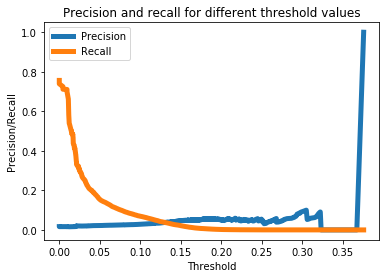

In [18]:
# get reconstruction rt
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, 
                                                               error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [19]:
threshold_rt

array([2.6646787e-05, 2.6646789e-05, 3.9632767e-03, ..., 3.6029249e-01,
       3.6754742e-01, 3.7598386e-01], dtype=float32)

0.03973963686193902
0.04823601505734045
0.03378813429403649


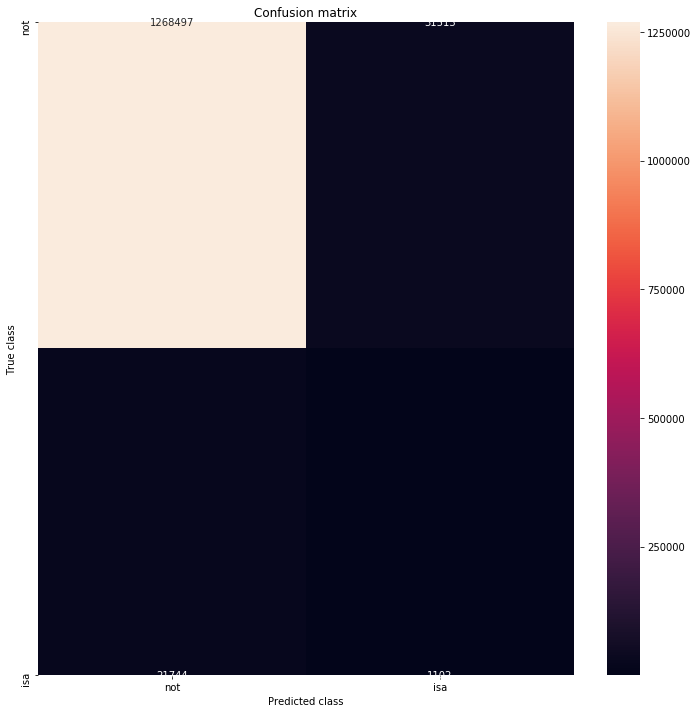

In [27]:
# get the confusion matrix
pred_y = [1 if e > 0.12 else 0 for e in error_df.Reconstruction_error.values]
print(f1_score(error_df.True_class, pred_y))
print(recall_score(error_df.True_class, pred_y))
print(precision_score(error_df.True_class, pred_y))
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# 4. Optimize with binary_crossentropy function

In [21]:
# initialize autoencoder
nb_epoch = 100
batch_size = 128
input_dim = train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 32
# hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='binary_crossentropy',
                    optimizer='sgd')
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1888      
_________________________________________________________________
dense_7 (Dense)              (None, 58)                1914      
Total params: 3,802
Trainable params: 3,802
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit autoencoder
autoencoder.fit(train_0_x, train_0_x,
                epochs=nb_epoch,
                batch_size=batch_size,
                validation_data=(validation_0_x, validation_0_x),
                shuffle=True,
                verbose=1)

Train on 1040008 samples, validate on 1300010 samples
Epoch 1/100
1040008/1040008 [==============================] - 16s 16us/step - loss: 1.7930 - accuracy: 0.5152 - val_loss: 2.0311 - val_accuracy: 0.4572
Epoch 2/100
1040008/1040008 [==============================] - 17s 16us/step - loss: 2.1979 - accuracy: 0.4271 - val_loss: 2.5393 - val_accuracy: 0.3918
Epoch 3/100
1040008/1040008 [==============================] - 17s 16us/step - loss: 2.5458 - accuracy: 0.4008 - val_loss: 2.5299 - val_accuracy: 0.4048
Epoch 4/100
1040008/1040008 [==============================] - 15s 14us/step - loss: 2.7500 - accuracy: 0.3799 - val_loss: 2.8036 - val_accuracy: 0.3608
Epoch 5/100
1040008/1040008 [==============================] - 15s 15us/step - loss: 2.8106 - accuracy: 0.3680 - val_loss: 2.7920 - val_accuracy: 0.3637
Epoch 6/100
1040008/1040008 [==============================] - 16s 15us/step - loss: 2.8048 - accuracy: 0.3616 - val_loss: 2.7901 - val_accuracy: 0.3594
Epoch 7/100
1040008/1040008 

Epoch 54/100
1040008/1040008 [==============================] - 15s 14us/step - loss: 3.7392 - accuracy: 0.2977 - val_loss: 3.7191 - val_accuracy: 0.2979
Epoch 55/100
1040008/1040008 [==============================] - 15s 14us/step - loss: 3.7392 - accuracy: 0.2979 - val_loss: 3.7191 - val_accuracy: 0.2979
Epoch 56/100
1040008/1040008 [==============================] - 15s 14us/step - loss: 3.7392 - accuracy: 0.2980 - val_loss: 3.7191 - val_accuracy: 0.2978
Epoch 57/100
1040008/1040008 [==============================] - 15s 14us/step - loss: 3.7392 - accuracy: 0.2980 - val_loss: 3.7191 - val_accuracy: 0.2980
Epoch 58/100
1040008/1040008 [==============================] - 15s 14us/step - loss: 3.7392 - accuracy: 0.2981 - val_loss: 3.7191 - val_accuracy: 0.2977
Epoch 59/100
1040008/1040008 [==============================] - 15s 14us/step - loss: 3.7392 - accuracy: 0.2978 - val_loss: 3.7191 - val_accuracy: 0.2963
Epoch 60/100
1040008/1040008 [==============================] - 15s 14us/ste

In [35]:
# get predictions of validation
valid_x_predictions = autoencoder.predict(validation_x)

In [29]:
# get reconstruction error
mse = np.mean(np.power(validation_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': validation['label']})

/home/linda/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


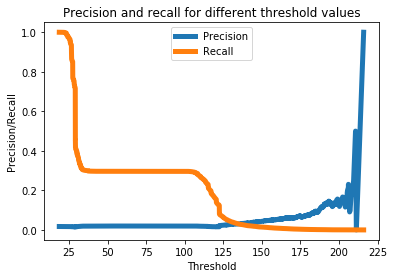

In [30]:
# get reconstruction rt
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, 
                                                               error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

0.03429710351254109
0.05799702354898013
0.024347666299154722


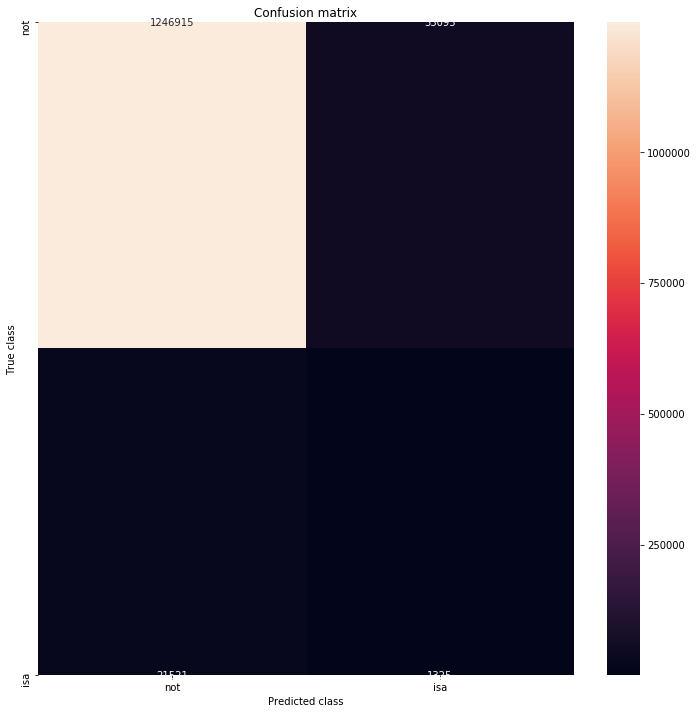

In [32]:
# get the confusion matrix
pred_y = [1 if e > 126 else 0 for e in error_df.Reconstruction_error.values]
print(f1_score(error_df.True_class, pred_y))
print(recall_score(error_df.True_class, pred_y))
print(precision_score(error_df.True_class, pred_y))
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# 5. Optimize Autoencoder - Linear

In [33]:
# initialize autoencoder
nb_epoch = 200
batch_size = 128
input_dim = train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 32
# hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='sgd')
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                1888      
_________________________________________________________________
dense_9 (Dense)              (None, 58)                1914      
Total params: 3,802
Trainable params: 3,802
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit autoencoder
autoencoder.fit(train_0_x, train_0_x,
                epochs=nb_epoch,
                batch_size=batch_size,
                validation_data=(validation_0_x, validation_0_x),
                shuffle=True,
                verbose=1)

Train on 1040008 samples, validate on 1300010 samples
Epoch 1/200
1040008/1040008 [==============================] - 13s 13us/step - loss: 0.0415 - accuracy: 0.4111 - val_loss: 0.0299 - val_accuracy: 0.4997
Epoch 2/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0254 - accuracy: 0.5302 - val_loss: 0.0220 - val_accuracy: 0.5854
Epoch 3/200
1040008/1040008 [==============================] - 14s 13us/step - loss: 0.0198 - accuracy: 0.5937 - val_loss: 0.0180 - val_accuracy: 0.6035
Epoch 4/200
1040008/1040008 [==============================] - 13s 13us/step - loss: 0.0166 - accuracy: 0.6116 - val_loss: 0.0154 - val_accuracy: 0.6197
Epoch 5/200
1040008/1040008 [==============================] - 14s 13us/step - loss: 0.0144 - accuracy: 0.6298 - val_loss: 0.0136 - val_accuracy: 0.6374
Epoch 6/200
1040008/1040008 [==============================] - 13s 13us/step - loss: 0.0129 - accuracy: 0.6420 - val_loss: 0.0122 - val_accuracy: 0.6437
Epoch 7/200
1040008/1040008 

Epoch 54/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0031 - accuracy: 0.6761 - val_loss: 0.0031 - val_accuracy: 0.6764
Epoch 55/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0031 - accuracy: 0.6760 - val_loss: 0.0030 - val_accuracy: 0.6757
Epoch 56/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0030 - accuracy: 0.6758 - val_loss: 0.0030 - val_accuracy: 0.6757
Epoch 57/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0030 - accuracy: 0.6759 - val_loss: 0.0030 - val_accuracy: 0.6768
Epoch 58/200
1040008/1040008 [==============================] - 13s 13us/step - loss: 0.0030 - accuracy: 0.6760 - val_loss: 0.0030 - val_accuracy: 0.6763
Epoch 59/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0029 - accuracy: 0.6768 - val_loss: 0.0029 - val_accuracy: 0.6764
Epoch 60/200
1040008/1040008 [==============================] - 12s 12us/ste

Epoch 160/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0020 - accuracy: 0.6872 - val_loss: 0.0020 - val_accuracy: 0.6725
Epoch 161/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0020 - accuracy: 0.6876 - val_loss: 0.0020 - val_accuracy: 0.6766
Epoch 162/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0020 - accuracy: 0.6842 - val_loss: 0.0020 - val_accuracy: 0.6966
Epoch 163/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0020 - accuracy: 0.6894 - val_loss: 0.0020 - val_accuracy: 0.6984
Epoch 164/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0020 - accuracy: 0.6903 - val_loss: 0.0020 - val_accuracy: 0.6962
Epoch 165/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0020 - accuracy: 0.6903 - val_loss: 0.0020 - val_accuracy: 0.6970
Epoch 166/200
1040008/1040008 [==============================] - 12s 1

In [36]:
# get predictions of validation
valid_x_predictions = autoencoder.predict(validation_x)

In [37]:
# get reconstruction error
mse = np.mean(np.power(validation_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': validation['label']})

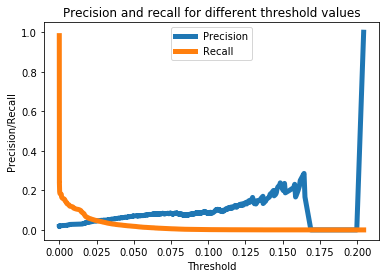

In [38]:
# get reconstruction rt
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, 
                                                               error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

0.04723628766686732
0.058390965595727914
0.03965988821500773


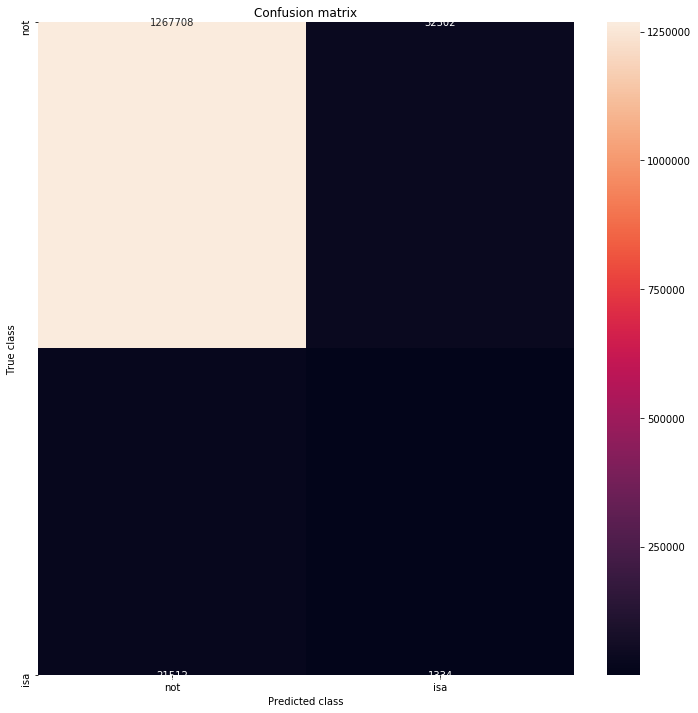

In [39]:
# get the confusion matrix
pred_y = [1 if e > 0.02 else 0 for e in error_df.Reconstruction_error.values]
print(f1_score(error_df.True_class, pred_y))
print(recall_score(error_df.True_class, pred_y))
print(precision_score(error_df.True_class, pred_y))
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# 5. Autoencoder with Adam

In [40]:
# initialize autoencoder
nb_epoch = 200
batch_size = 128
input_dim = train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 32
# hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True) 
decoder = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                1888      
_________________________________________________________________
dense_11 (Dense)             (None, 58)                1914      
Total params: 3,802
Trainable params: 3,802
Non-trainable params: 0
_________________________________________________________________


In [41]:
# fit autoencoder
autoencoder.fit(train_0_x, train_0_x,
                epochs=nb_epoch,
                batch_size=batch_size,
                validation_data=(validation_0_x, validation_0_x),
                shuffle=True,
                verbose=1)

Train on 1040008 samples, validate on 1300010 samples
Epoch 1/200
1040008/1040008 [==============================] - 14s 14us/step - loss: 0.0030 - accuracy: 0.6873 - val_loss: 0.0018 - val_accuracy: 0.6952
Epoch 2/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6946 - val_loss: 0.0018 - val_accuracy: 0.7489
Epoch 3/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0018 - accuracy: 0.6935 - val_loss: 0.0018 - val_accuracy: 0.7222
Epoch 4/200
1040008/1040008 [==============================] - 12s 12us/step - loss: 0.0018 - accuracy: 0.6949 - val_loss: 0.0018 - val_accuracy: 0.7075
Epoch 5/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6973 - val_loss: 0.0018 - val_accuracy: 0.6986
Epoch 6/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6970 - val_loss: 0.0018 - val_accuracy: 0.7138
Epoch 7/200
1040008/1040008 

Epoch 54/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6996 - val_loss: 0.0018 - val_accuracy: 0.6975
Epoch 55/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6983 - val_loss: 0.0018 - val_accuracy: 0.6834
Epoch 56/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6993 - val_loss: 0.0018 - val_accuracy: 0.7048
Epoch 57/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6988 - val_loss: 0.0018 - val_accuracy: 0.7308
Epoch 58/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6995 - val_loss: 0.0018 - val_accuracy: 0.7190
Epoch 59/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6970 - val_loss: 0.0018 - val_accuracy: 0.6968
Epoch 60/200
1040008/1040008 [==============================] - 13s 12us/ste

Epoch 160/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6969 - val_loss: 0.0018 - val_accuracy: 0.7372
Epoch 161/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6999 - val_loss: 0.0018 - val_accuracy: 0.7239
Epoch 162/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6997 - val_loss: 0.0018 - val_accuracy: 0.7033
Epoch 163/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6986 - val_loss: 0.0018 - val_accuracy: 0.6971
Epoch 164/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6989 - val_loss: 0.0018 - val_accuracy: 0.7256
Epoch 165/200
1040008/1040008 [==============================] - 13s 12us/step - loss: 0.0018 - accuracy: 0.6979 - val_loss: 0.0018 - val_accuracy: 0.7018
Epoch 166/200
1040008/1040008 [==============================] - 13s 1

In [42]:
# get predictions of validation
valid_x_predictions = autoencoder.predict(validation_x)

In [43]:
# get reconstruction error
mse = np.mean(np.power(validation_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': validation['label']})

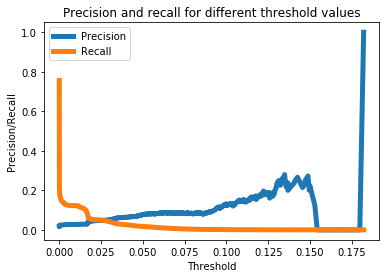

In [44]:
# get reconstruction rt
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, 
                                                               error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

0.04888649811726734
0.04972424056727655
0.048076516145414534


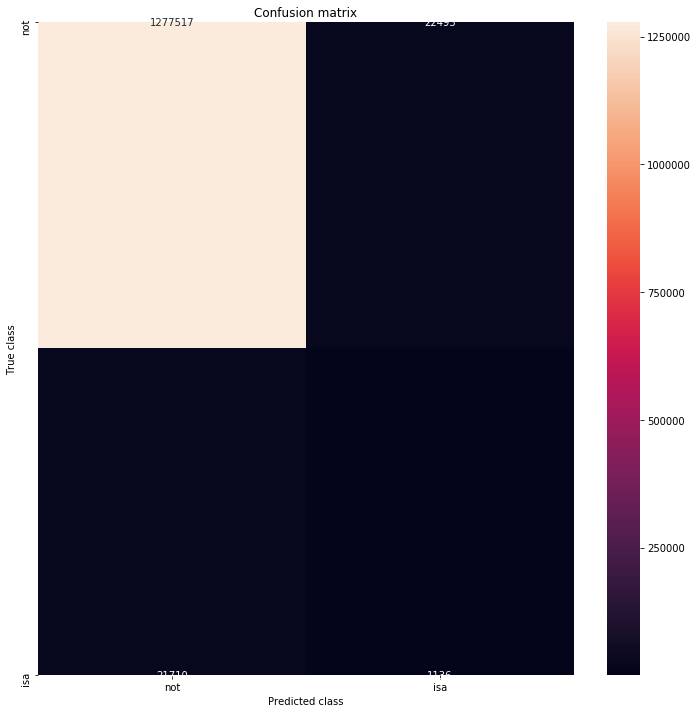

In [45]:
# get the confusion matrix
pred_y = [1 if e > 0.025 else 0 for e in error_df.Reconstruction_error.values]
print(f1_score(error_df.True_class, pred_y))
print(recall_score(error_df.True_class, pred_y))
print(precision_score(error_df.True_class, pred_y))
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# 6. Autoencoder tune 2 Tied Layer

In [46]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [47]:
# initialize autoencoder
nb_epoch = 100 # TODO: change number of epochs
batch_size = 64
input_dim = train_0_x.shape[1] #num of predictor variables, 
encoding_dim = 2
# hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), use_bias = True) 
decoder = DenseTied(input_dim, activation="linear", tied_to=encoder, use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 2)                 118       
_________________________________________________________________
dense_tied_1 (DenseTied)     (None, 58)                292       
Total params: 292
Trainable params: 176
Non-trainable params: 116
_________________________________________________________________


In [48]:
autoencoder.fit(train_0_x, train_0_x,
                epochs=nb_epoch,
                batch_size=batch_size,
                validation_data=(validation_0_x, validation_0_x),
                shuffle=True,
                verbose=1)

Train on 1040008 samples, validate on 1300010 samples
Epoch 1/100
1040008/1040008 [==============================] - 21s 20us/step - loss: 0.0243 - accuracy: 0.3391 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 2/100
1040008/1040008 [==============================] - 23s 22us/step - loss: 0.0240 - accuracy: 0.3426 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 3/100
1040008/1040008 [==============================] - 27s 26us/step - loss: 0.0240 - accuracy: 0.3427 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 4/100
1040008/1040008 [==============================] - 25s 24us/step - loss: 0.0240 - accuracy: 0.3427 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 5/100
1040008/1040008 [==============================] - 25s 24us/step - loss: 0.0240 - accuracy: 0.3426 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 6/100
1040008/1040008 [==============================] - 25s 24us/step - loss: 0.0240 - accuracy: 0.3430 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 7/100
1040008/1040008 

Epoch 54/100
1040008/1040008 [==============================] - 20s 20us/step - loss: 0.0240 - accuracy: 0.3426 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 55/100
1040008/1040008 [==============================] - 20s 20us/step - loss: 0.0240 - accuracy: 0.3421 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 56/100
1040008/1040008 [==============================] - 21s 20us/step - loss: 0.0240 - accuracy: 0.3425 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 57/100
1040008/1040008 [==============================] - 20s 20us/step - loss: 0.0240 - accuracy: 0.3428 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 58/100
1040008/1040008 [==============================] - 20s 20us/step - loss: 0.0240 - accuracy: 0.3428 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 59/100
1040008/1040008 [==============================] - 20s 20us/step - loss: 0.0240 - accuracy: 0.3424 - val_loss: 0.0241 - val_accuracy: 0.3430
Epoch 60/100
1040008/1040008 [==============================] - 20s 20us/ste

In [49]:
# get predictions of validation
valid_x_predictions = autoencoder.predict(validation_x)

In [50]:
# get reconstruction error
mse = np.mean(np.power(validation_x - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': validation['label']})

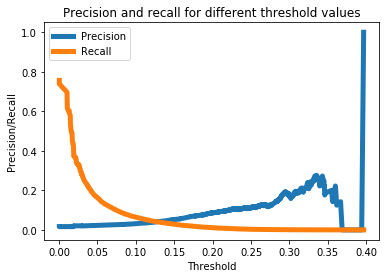

In [51]:
# get reconstruction rt
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, 
                                                               error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

0.03316461542902782
0.6034316729405585
0.017050865653624764


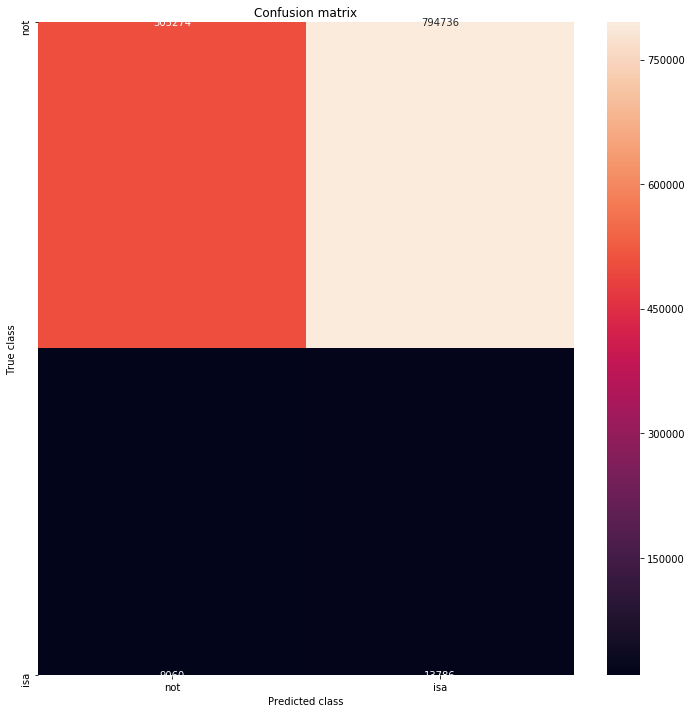

In [55]:
# get the confusion matrix
pred_y = [1 if e > 0.012 else 0 for e in error_df.Reconstruction_error.values]
print(f1_score(error_df.True_class, pred_y))
print(recall_score(error_df.True_class, pred_y))
print(precision_score(error_df.True_class, pred_y))
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# 7. Autoencoder with orthogonal weights

In [21]:
class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = K.transpose(w)
        if(self.encoding_dim > 1):
            m = K.dot(K.transpose(w), w) - K.eye(self.encoding_dim)
            return self.weightage * K.sqrt(K.sum(K.square(m)))
        else:
            m = K.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)

In [22]:
encoder = Dense(encoding_dim, activation="linear", input_shape=(input_dim,), 
                use_bias=True, kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, 
                                                                                 weightage=1., axis=0)) 
decoder = Dense(input_dim, activation="linear", use_bias = True, 
                kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=1))

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='sgd')
autoencoder.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 118       
_________________________________________________________________
dense_4 (Dense)              (None, 58)                174       
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
autoencoder.fit(train_0_x, train_0_x,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data = (validation_0_x, validation_0_x),
                verbose=1)

Train on 1040008 samples, validate on 1300010 samples
Epoch 1/100
1040008/1040008 [==============================] - 33s 31us/step - loss: 0.0770 - accuracy: 0.2684 - val_loss: 0.0923 - val_accuracy: 0.2791
Epoch 2/100
1040008/1040008 [==============================] - 32s 31us/step - loss: 0.0690 - accuracy: 0.2894 - val_loss: 0.0720 - val_accuracy: 0.3440
Epoch 3/100
1040008/1040008 [==============================] - 33s 31us/step - loss: 0.0666 - accuracy: 0.3434 - val_loss: 0.0574 - val_accuracy: 0.3441
Epoch 4/100
1040008/1040008 [==============================] - 33s 31us/step - loss: 0.0653 - accuracy: 0.3434 - val_loss: 0.0567 - val_accuracy: 0.3440
Epoch 5/100
1040008/1040008 [==============================] - 36s 35us/step - loss: 0.0646 - accuracy: 0.3430 - val_loss: 0.0835 - val_accuracy: 0.3434
Epoch 6/100
1040008/1040008 [==============================] - 34s 33us/step - loss: 0.0643 - accuracy: 0.3426 - val_loss: 0.0509 - val_accuracy: 0.3430
Epoch 7/100
1040008/1040008 

Epoch 54/100
1040008/1040008 [==============================] - 31s 30us/step - loss: 0.0640 - accuracy: 0.3424 - val_loss: 0.0615 - val_accuracy: 0.3430
Epoch 55/100
1040008/1040008 [==============================] - 36s 35us/step - loss: 0.0640 - accuracy: 0.3424 - val_loss: 0.0897 - val_accuracy: 0.3430
Epoch 56/100
1040008/1040008 [==============================] - 33s 32us/step - loss: 0.0640 - accuracy: 0.3424 - val_loss: 0.0545 - val_accuracy: 0.3430
Epoch 57/100
1040008/1040008 [==============================] - 32s 31us/step - loss: 0.0640 - accuracy: 0.3424 - val_loss: 0.0797 - val_accuracy: 0.3430
Epoch 58/100
1040008/1040008 [==============================] - 31s 30us/step - loss: 0.0640 - accuracy: 0.3424 - val_loss: 0.0289 - val_accuracy: 0.3430
Epoch 59/100
1040008/1040008 [==============================] - 33s 31us/step - loss: 0.0640 - accuracy: 0.3424 - val_loss: 0.0813 - val_accuracy: 0.3430
Epoch 60/100
1040008/1040008 [==============================] - 33s 32us/ste

In [ ]:
# get predictions of validation
valid_x_predictions = autoencoder.predict(validation_x)